## Money Ball

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

C:\Users\Samsung\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Samsung\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Sabermetrics

Using data preceding the 2002 season we pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary) and predict how many games this team would win in a 162 game season.  

We will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. We will explore the data in this database from before 2002 and create a metric for picking players. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [2]:
def getZIP(zipFileName):
    r = requests.get(zipFileName).content
    s = StringIO.StringIO(r)
    zf = zipfile.ZipFile(s, 'r') # Read in a list of zipped files
    return zf

url = 'http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip'
zf = getZIP(url)
tablenames = zf.namelist()
print tablenames

['SchoolsPlayers.csv', 'SeriesPost.csv', 'Teams.csv', 'TeamsFranchises.csv', 'TeamsHalf.csv', 'AllstarFull.csv', 'Appearances.csv', 'AwardsManagers.csv', 'AwardsPlayers.csv', 'AwardsShareManagers.csv', 'AwardsSharePlayers.csv', 'Batting.csv', 'BattingPost.csv', 'Fielding.csv', 'FieldingOF.csv', 'FieldingPost.csv', 'HallOfFame.csv', 'Managers.csv', 'ManagersHalf.csv', 'Master.csv', 'Pitching.csv', 'PitchingPost.csv', 'readme2013.txt', 'Salaries.csv', 'Schools.csv']


In [3]:
teams = pd.read_csv(zf.open(tablenames[tablenames.index('Teams.csv')]))
players = pd.read_csv(zf.open(tablenames[tablenames.index('Batting.csv')]))
salaries = pd.read_csv(zf.open(tablenames[tablenames.index('Salaries.csv')]))
fielding = pd.read_csv(zf.open(tablenames[tablenames.index('Fielding.csv')]))
master = pd.read_csv(zf.open(tablenames[tablenames.index('Master.csv')]))

We Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player and hence how the head of the `medianSalaries` DataFrame.   

In [4]:
byPlayerID = salaries.groupby('playerID')['playerID','salary'].median()
medianSalaries = pd.merge(master[['playerID', 'nameFirst', 'nameLast']], byPlayerID, \
                  left_on='playerID', right_index = True, how="inner")
medianSalaries.head()

,playerID,nameFirst,nameLast,salary
0,aardsda01,David,Aardsma,419000
3,aasedo01,Don,Aase,612500
4,abadan01,Andy,Abad,327000
5,abadfe01,Fernando,Abad,451500
13,abbotje01,Jeff,Abbott,255000


Now, we consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. We create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [5]:
subTeams = teams[(teams['G'] == 162) & (teams['yearID'] > 1947)].copy()

subTeams["1B"] = subTeams.H - subTeams["2B"] - subTeams["3B"] - subTeams["HR"]
subTeams["PA"] = subTeams.BB + subTeams.AB

for col in ["1B","2B","3B","HR","BB"]:
    subTeams[col] = subTeams[col]/subTeams.PA
    
stats = subTeams[["teamID","yearID","W","1B","2B","3B","HR","BB"]].copy()
stats.head()

,teamID,yearID,W,1B,2B,3B,HR,BB
1366,LAA,1961,70,0.147748,0.035708,0.003604,0.030958,0.111548
1367,KC1,1961,61,0.164751,0.035982,0.007829,0.014993,0.096618
1377,NYA,1962,96,0.167148,0.038536,0.004656,0.031952,0.093770
1379,LAA,1962,86,0.159482,0.038027,0.005737,0.022455,0.098672
1381,CHA,1962,85,0.165797,0.040756,0.009129,0.014998,0.101076


*Let's try and figure out a possible trend in rate over time*

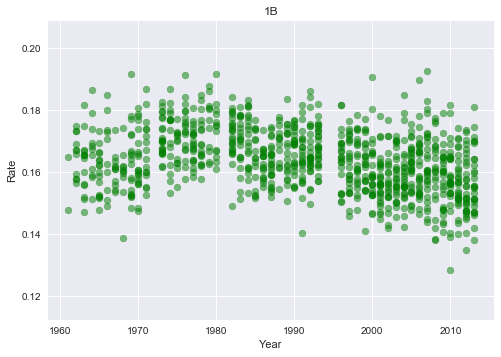

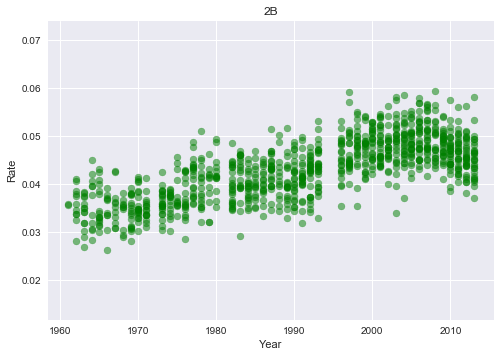

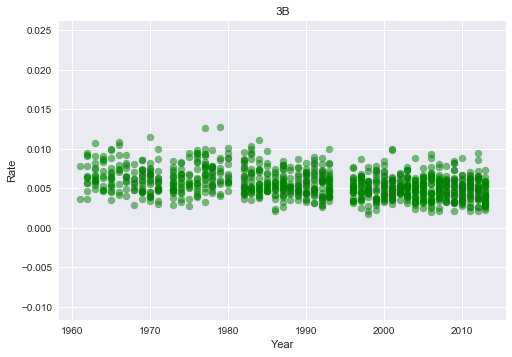

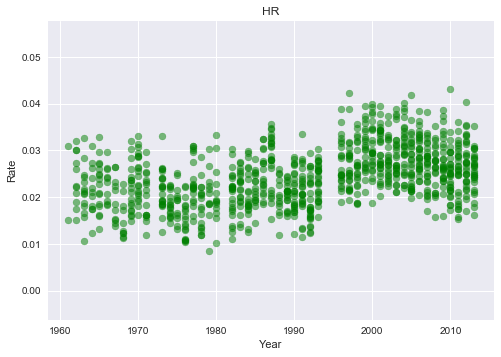

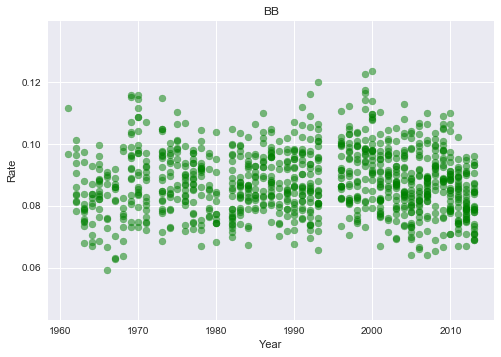

In [6]:
for col in ["1B","2B","3B","HR","BB"]:
    plt.scatter(stats.yearID, stats[col], c="g", alpha=0.5)
    plt.title(col)
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.show()

let's check what the mean is across teams for each year for each of the rates.

In [7]:
stats.groupby('yearID')["1B","2B","3B","HR","BB"].mean().head()


,1B,2B,3B,HR,BB
yearID,,,,,
1961,0.156249,0.035845,0.005717,0.022975,0.104083
1962,0.165632,0.035853,0.006777,0.023811,0.088590
1963,0.162467,0.034020,0.006896,0.021254,0.080336
1964,0.167251,0.036336,0.006748,0.021548,0.079152
1965,0.160042,0.035539,0.006534,0.022693,0.085745


In [8]:
def meanNormalizeRates(df):
        subRates = df[["1B","2B","3B","HR","BB"]]
        df[["1B","2B","3B","HR","BB"]] = subRates - subRates.mean(axis=0)
        return df

stats = stats.groupby('yearID').apply(meanNormalizeRates)

We will build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002 and hence use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW).

In [9]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

stat_train = stats[stats.yearID < 2002]
stat_test = stats[stats.yearID >= 2002]

XX_train = stat_train[["1B","2B","3B","HR","BB"]].values
XX_test = stat_test[["1B","2B","3B","HR","BB"]].values

YY_train = stat_train.W.values
YY_test = stat_test.W.values
clf.fit(XX_train,YY_train)
clf.coef_

print("Mean squared error: %.2f"
      % np.mean((YY_test - clf.predict(XX_test)) ** 2))

Mean squared error: 83.82


Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances we will consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year we compute singles, doubles, triples, HR, BB per plate appearance rates and  create a new pandas DataFrame called playerstats that has the playerID, yearID and the rates of these stats removing the average for each year as for these rates.

First we will subset the players DataFrame for players with at least 500 plate appearances and for years after 1947.

In [10]:
subPlayers = players[(players.AB + players.BB > 500)  & (players.yearID > 1947)].copy()

subPlayers["1B"] = subPlayers.H - subPlayers["2B"] - subPlayers["3B"] - subPlayers["HR"]
subPlayers["PA"] = subPlayers.BB + subPlayers.AB

for col in ["1B","2B","3B","HR","BB"]:
    subPlayers[col] = subPlayers[col]/subPlayers.PA

# Create playerstats DataFrame
playerstats = subPlayers[["playerID","yearID","1B","2B","3B","HR","BB"]].copy()

playerstats = playerstats.groupby('yearID').apply(meanNormalizeRates)

playerstats.head()

,playerID,yearID,1B,2B,3B,HR,BB
8,aaronha01,1955,0.001060,0.018570,0.005585,0.011337,-0.027249
9,aaronha01,1956,0.021561,0.013857,0.012480,0.009593,-0.044600
10,aaronha01,1957,0.004817,-0.002034,0.000466,0.037093,-0.013166
11,aaronha01,1958,0.018367,0.011015,-0.002219,0.015398,-0.007762
12,aaronha01,1959,0.016261,0.025762,0.002743,0.028368,-0.022898


Using the playerstats DataFrame created before, we create a new DataFrame called playerLS containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the average of the rates by year (a more correct way is to go back to the totals).

First we will create a function called meanNormalizePlayerLS that computes the lifetime average for each of the quantities (singles, doubles, triples, HR, BB). Then we will construct a function called getyear that extracts the year from a date as saved in the master table.

In [11]:
def meanNormalizePlayerLS(df):
    df = df[['playerID', '1B','2B','3B','HR','BB']].mean()
    return df

def getyear(x):
    return int(x[0:4])

Next, we use groupby (by playerID) on the playerstats DataFrame to compute the average lifetime statistics (1B, 2B, 3B, HR and BB) for each player.

In [12]:
playerLS = playerstats.groupby('playerID').apply(meanNormalizePlayerLS).reset_index()

Then, we merge playerLS with the master DataFrame which contains the career start and end.

In [13]:
playerLS = master[["playerID","debut","finalGame"]].merge(playerLS, how='inner', on="playerID")
playerLS.head()

,playerID,debut,finalGame,1B,2B,3B,HR,BB
0,aaronha01,1954-04-13,1976-10-03,-0.007157,0.006539,-0.000270,0.027850,0.009447
1,abramca01,1949-04-20,1956-05-09,0.013463,-0.023915,0.002384,0.003842,0.019455
2,abreubo01,1996-09-01,2012-10-02,-0.008202,0.006421,0.001002,-0.003252,0.050501
3,ackledu01,2011-06-17,2013-09-29,-0.009270,-0.016605,-0.001974,-0.015274,0.001597
4,adairje01,1958-09-02,1970-05-03,0.011933,0.003286,-0.002139,-0.012934,-0.037229


Finally, we extract the year from the debut and finalGame column to determine what year each player started and ended their career.

In [14]:
playerLS["debut"] = playerLS.debut.apply(getyear)
playerLS["finalGame"] = playerLS.finalGame.apply(getyear)
cols = list(playerLS.columns)
cols[1:3]=["minYear","maxYear"]
playerLS.columns = cols
playerLS.head()

,playerID,minYear,maxYear,1B,2B,3B,HR,BB
0,aaronha01,1954,1976,-0.007157,0.006539,-0.000270,0.027850,0.009447
1,abramca01,1949,1956,0.013463,-0.023915,0.002384,0.003842,0.019455
2,abreubo01,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501
3,ackledu01,2011,2013,-0.009270,-0.016605,-0.001974,-0.015274,0.001597
4,adairje01,1958,1970,0.011933,0.003286,-0.002139,-0.012934,-0.037229


We compute the OPW for each player based on the average rates in the playerLS DataFrame. The OPW will represent a team of 9 such similar players.

In [15]:
avgRates = playerLS[["1B","2B","3B","HR","BB"]].values
playerLS["OPW"] = clf.predict(avgRates)
playerLS.head()

,playerID,minYear,maxYear,1B,2B,3B,HR,BB,OPW
0,aaronha01,1954,1976,-0.007157,0.006539,-0.000270,0.027850,0.009447,108.696139
1,abramca01,1949,1956,0.013463,-0.023915,0.002384,0.003842,0.019455,92.575472
2,abreubo01,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008
3,ackledu01,2011,2013,-0.009270,-0.016605,-0.001974,-0.015274,0.001597,53.806003
4,adairje01,1958,1970,0.011933,0.003286,-0.002139,-0.012934,-0.037229,56.395050


We add four columns to the playerLS DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF), first name, last name and median salary.

In [16]:
from collections import defaultdict

def find_pos(df):
    positions = df.POS
    d = defaultdict(int)
    for pos in positions:
        d[pos] += 1
    result = max(d.iteritems(), key=lambda x: x[1])
    return result[0]

positions_df = fielding.groupby("playerID").apply(find_pos)
positions_df = positions_df.reset_index()
positions_df = positions_df.rename(columns={0:"POS"})
playerLS_merged = positions_df.merge(playerLS, how='inner', on="playerID")
playerLS_merged = playerLS_merged.merge(medianSalaries, how='inner', on=['playerID'])
playerLS_merged.head()

,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary
0,abreubo01,RF,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008,Bobby,Abreu,9000000
1,ackledu01,1B,2011,2013,-0.009270,-0.016605,-0.001974,-0.015274,0.001597,53.806003,Dustin,Ackley,2400000
2,adamsru01,SS,2004,2009,-0.007867,-0.001289,0.004160,-0.017533,0.002672,67.496507,Russ,Adams,329500
3,alfoned01,2B,1995,2006,0.013485,-0.002177,-0.003239,-0.006436,0.010745,83.404437,Edgardo,Alfonzo,4112500
4,alicelu01,2B,1988,2002,0.035625,-0.009597,0.007988,-0.026156,-0.006580,78.561778,Luis,Alicea,750000


Subset the playerLS DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins.

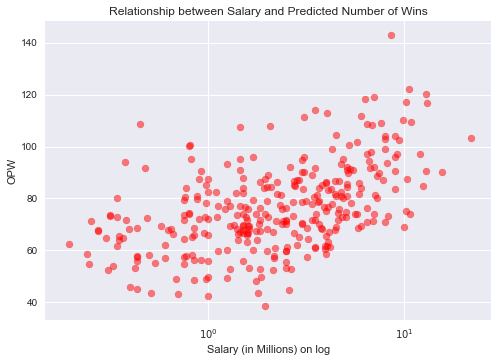

In [17]:
active = playerLS_merged[(playerLS_merged["minYear"] <= 2002) & \
                         (playerLS_merged["maxYear"] >= 2003) & \
                         (playerLS_merged["maxYear"] - playerLS_merged["minYear"] >= 3)  ]
fig = plt.figure()
ax = fig.gca()
ax.scatter(active.salary/10**6, active.OPW, alpha=0.5, c='red')
ax.set_xscale('log')
ax.set_xlabel('Salary (in Millions) on log')
ax.set_ylabel('OPW')
ax.set_title('Relationship between Salary and Predicted Number of Wins')
plt.show()

Note some players stand out as underpaid: points higher than the line.

We pick one player from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.
There are many ways to do this. This is just one example that can still be optimized. The basic idea is to iterate 10 times through an algorithm that selects players. In each iteration we pick a different position. We keep track of the bare minimum we would need to complete a team and keep at least that amount during each iteration. At each iteration we pick the player we can afford having the highest deviation from expected OPW given their salary.

First, we mean normalize the OPW by position to compute a position specific residual using the meanNormalizeOPW function.

In [18]:
def meanNormalizeOPW(df):
    tmp = df[['resid']] 
    df[['resid']]=tmp-tmp.mean(axis=0)
    return df

active['resid']=active['OPW']
active = active.groupby('POS').apply(meanNormalizeOPW)

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
Y = active.resid.values
X = np.log(active[["salary"]])

clf = linear_model.LinearRegression()
clf.fit(X,Y)

active['resid'] = Y - clf.predict(X)

We can take out the below average players.

In [20]:
active = active[active.resid >= 0]

Next, we calculate the min salary by position. We will use thos to know what is the minimum amount of money we need to keep (and know how much we can spend).

In [21]:
def getMinSalary(s):
    return s["salary"].min()

minSalaryByPos = active.groupby('POS').apply(getMinSalary)
minSalaryByPos.sort(ascending=False)

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [22]:
posleft = list(minSalaryByPos.index)
print posleft

['RF', 'CF', 'DH', '3B', '1B', 'C', 'OF', 'SS', '2B', 'LF']


In [23]:
minSalaryByPos

POS
RF    1700000
CF    1500000
DH    1450000
3B     432500
1B     375000
C      350000
OF     315000
SS     314750
2B     275000
LF     195000
dtype: int64

In [24]:
moneyleft = 20*10**6

Now, we will iterate through all the positions. We keep track of the bare minimum we would need to complete a team and keep at least that amount during each iteration. At each iteration we pick the player we can afford having the highest deviation from expected OPW given their salary.

In [25]:
indexes=[]
    
for i in range(len(posleft)):
    
    # you need to have at least this much left to not go over in the next picks
    maxmoney = moneyleft - sum([minSalaryByPos[x] for x in posleft[1:] ])
    
    # consider only players in positions we have not selected
    index = [True if elem in posleft else False for elem in active.POS.values]
    left = active[index & (active.salary <= maxmoney)]
    
    # pick the one that stands out the most from what is expected given his salary
    j = left["resid"].argmax()
    indexes.append(j)
    
    # remove position we just filled from posleft
    posleft.remove(left.loc[j].POS)
    moneyleft = moneyleft - left.loc[j].salary
   
topPicks=active.loc[indexes,:]
topPicks=topPicks.sort(["OPW"],ascending=False)

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [26]:
moneyleft

253583

In [27]:
topPicks

,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary,resid
81,bondsba01,OF,1986,2007,-0.045184,0.001342,0.001377,0.030717,0.112071,143.101202,Barry,Bonds,8541667,52.472598
582,martied01,DH,1987,2004,0.000910,0.011751,-0.003912,0.004922,0.052827,113.934171,Edgar,Martinez,3500000,12.932211
274,ensbemo01,3B,2000,2008,-0.033243,-0.003037,-0.000346,0.026321,0.047626,108.584662,Morgan,Ensberg,450000,47.660066
475,johnsni01,1B,2001,2012,-0.030406,0.018102,-0.002523,-0.000333,0.072075,107.537577,Nick,Johnson,1450000,24.880900
236,delluda01,LF,1997,2009,-0.050673,-0.018869,0.004528,0.024153,0.057238,100.483979,David,Dellucci,812500,32.635107
922,werthja01,RF,2002,2013,-0.015169,-0.000742,-0.003539,0.012239,0.032909,95.991832,Jayson,Werth,1700000,11.266350
55,bellhma01,2B,1997,2007,-0.039044,0.002241,0.001326,0.005377,0.046554,91.598047,Mark,Bellhorn,477500,32.023745
872,torrean02,CF,2002,2013,-0.038587,0.025363,0.009017,-0.003139,0.006371,83.881250,Andres,Torres,1500000,15.703571
966,zaungr01,C,1995,2010,-0.008357,-0.016634,-0.003284,-0.010903,0.052494,82.532772,Gregg,Zaun,1000000,16.228394
611,menecfr01,SS,1999,2005,-0.021680,-0.011214,-0.001739,-0.014485,0.046071,73.581041,Frank,Menechino,314750,25.703669


In [28]:
topPicks['salary'].sum()

19746417

The total salary is 19.7 million.

In [29]:
round(topPicks['OPW'].mean())

100.0

We expect 100 wins

What do these players outperform in? Singles, doubles, triples HR or BB?

In [30]:
def round1000(x):
    return np.round(x*1000)

topPicks[["1B","2B","3B", "HR","BB"]] = topPicks[["1B","2B","3B", "HR","BB"]].apply(round1000)
topPicks[["OPW"]] = np.round(topPicks[["OPW"]])
topPicks[["nameFirst","nameLast","POS","1B","2B","3B", "HR","BB","OPW","salary","minYear","maxYear"]]

,nameFirst,nameLast,POS,1B,2B,3B,HR,BB,OPW,salary,minYear,maxYear
81,Barry,Bonds,OF,-45.0,1.0,1.0,31.0,112.0,143.0,8541667,1986,2007
582,Edgar,Martinez,DH,1.0,12.0,-4.0,5.0,53.0,114.0,3500000,1987,2004
274,Morgan,Ensberg,3B,-33.0,-3.0,0.0,26.0,48.0,109.0,450000,2000,2008
475,Nick,Johnson,1B,-30.0,18.0,-3.0,0.0,72.0,108.0,1450000,2001,2012
236,David,Dellucci,LF,-51.0,-19.0,5.0,24.0,57.0,100.0,812500,1997,2009
922,Jayson,Werth,RF,-15.0,-1.0,-4.0,12.0,33.0,96.0,1700000,2002,2013
55,Mark,Bellhorn,2B,-39.0,2.0,1.0,5.0,47.0,92.0,477500,1997,2007
872,Andres,Torres,CF,-39.0,25.0,9.0,-3.0,6.0,84.0,1500000,2002,2013
966,Gregg,Zaun,C,-8.0,-17.0,-3.0,-11.0,52.0,83.0,1000000,1995,2010
611,Frank,Menechino,SS,-22.0,-11.0,-2.0,-14.0,46.0,74.0,314750,1999,2005


Our best players all outperformed in BB.